# Descriptive statistics


In [1]:
# Imports

# interactive widget imports
import ipywidgets as wg
from IPython.display import display


# data handling modules
import pandas as pd
import numpy as np
from datetime import datetime

# plotting imports
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from plotly import tools
plotly.tools.set_credentials_file(username='halima.schede', api_key='0BXIz4i3MnnYF4z7QhA0')
plt.style.use('seaborn')

# web scraping
from bs4 import BeautifulSoup
import requests

# other helpers and suppress warnings
from helpers import *
from timeline_helpers import *
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

### Columns description

In [2]:
tweets1 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_1.csv')
tweets1.head(1)

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll


For a proper description of each column go here: https://www.kaggle.com/fivethirtyeight/russian-troll-tweets/home

Out of these colums we have no interest in **harvested_date** and **new_june_2018**, since they contain information concerning the collection of the data and not the content itself.

In [3]:
cols_to_extract = [0,1,2,3,4,5,7,8,9,10,11,13,14]

### Data extraction

In [4]:
tweets1 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_1.csv', usecols=cols_to_extract)
tweets2 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_2.csv', usecols=cols_to_extract)
tweets3 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_3.csv', usecols=cols_to_extract)
tweets4 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_4.csv', usecols=cols_to_extract) 
tweets5 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_5.csv', usecols=cols_to_extract)
tweets6 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_6.csv', usecols=cols_to_extract)
tweets7 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_7.csv', usecols=cols_to_extract) 
tweets8 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_8.csv', usecols=cols_to_extract) 
tweets9 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_9.csv', usecols=cols_to_extract)

In [5]:
tweets = pd.concat([tweets1,tweets2,tweets3,tweets4,tweets5,tweets6,tweets7,tweets8,tweets9], axis=0)
tweets.head(2)

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,retweet,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,1052,9636,253,NaN,Right,0,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,1054,9637,254,NaN,Right,0,RightTroll


In [6]:
del tweets1
del tweets2
del tweets3
del tweets4
del tweets5
del tweets6
del tweets7
del tweets8
del tweets9

### Data formats

The different data columns are transformed into appropriated data type:

+ external_author_id, author, region, language, post_type, account_type, retweet, account_category to categorical;
+ publish_date to datetime;
+ content (the actual tweet) to string type;
+ int64 types are left as int64 since they are counting variables.




In [7]:
tweets['content'] = tweets.content.astype(str)

tweets[['external_author_id', 'author', 'region', 'language', 'post_type', 'account_type', 'retweet', 'account_category']] = \
tweets[['external_author_id', 'author', 'region', 'language', 'post_type', 'account_type', 'retweet', 'account_category']].astype('category')

tweets['publish_date'] = pd.to_datetime(tweets['publish_date'], format='%m/%d/%Y %H:%M')

tweets.dtypes

external_author_id          category
author                      category
content                       object
region                      category
language                    category
publish_date          datetime64[ns]
following                      int64
followers                      int64
updates                        int64
post_type                   category
account_type                category
retweet                     category
account_category            category
dtype: object

## Dataset description

### General Numbers and Statistics

In [8]:
print('The total number of tweets in the unfiltered dataset is {}'.format(tweets.shape[0]))

The total number of tweets in the unfiltered dataset is 2973371


### Authors and followers

Authors are defined by their twitter username. To understand to what extent a single author can influence the Twitter newsfeed, one needs to take into consideration different aspects:

+ each author reaches through time different followers, which is a quantity that shows how many people could have potentially read the author's tweets
+ each author has been assigned to a certain account_category that defines the troll's purpose and main tweeting subject


In [9]:
print('There are {} unique authors. Divided in categories in this way:\n\n{}'
      .format(tweets.author.cat.categories.shape[0],
              tweets[['author','account_category']].drop_duplicates().account_category.value_counts()))

There are 2848 unique authors. Divided in categories in this way:

NonEnglish      1475
RightTroll       630
LeftTroll        233
Unknown          214
Fearmonger       124
HashtagGamer     112
NewsFeed          54
Commercial         6
Name: account_category, dtype: int64


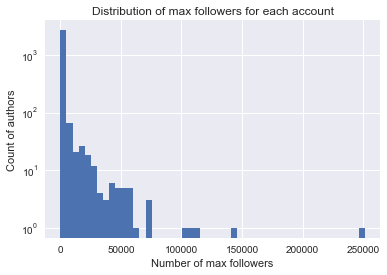

In [10]:
tweets.groupby('author')['followers'].max().dropna().hist(log=True, bins=50)
plt.title('Distribution of max followers for each account')
plt.xlabel('Number of max followers')
plt.ylabel('Count of authors')
plt.show()

In [11]:
print('Each account belongs to one these categories(with the exception of Fearmonger that can be attributed to sile tweets):\n\n {}'
      .format(list(tweets.account_category.cat.categories)))

Each account belongs to one these categories(with the exception of Fearmonger that can be attributed to sile tweets):

 ['Commercial', 'Fearmonger', 'HashtagGamer', 'LeftTroll', 'NewsFeed', 'NonEnglish', 'RightTroll', 'Unknown']


In [12]:
print('NB: The user can toggle the other categories not displayed.')

data = []

for cat in reversed(tweets.account_category.cat.categories):

    acc_cat = tweets[['author','followers']][tweets.account_category == cat]
    extracted_followers = acc_cat.groupby('author')['followers'].max().dropna().values
    
    if(cat == 'RightTroll' or cat=='LeftTroll'):
        trace = go.Box(
                    y=extracted_followers[extracted_followers>0],
                    name=cat,
                    boxpoints='all'
        )
    
    else:
        trace = go.Box(
                        y=extracted_followers[extracted_followers>0],
                        name=cat,
                        boxpoints='all',
                        visible= 'legendonly'
                )
    
    data.append(trace)
    
layout = go.Layout(title = 'Distribution of account followers per category',
                   yaxis=dict(type='log',autorange=True,showgrid=True))
    
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='chart1')

NB: The user can toggle the other categories not displayed.


Interestingly we see that for categories 'RightTroll', 'LefTroll' and 'HashtagGamer' seem to have a bimodal distribution of number of followers per account. Specifically for left and right troll there seem to be a population around 100 followers and another around 1000 followers, we currently cannot explain where this two populations may come from

### Search for outliers

##### Following and followers distribution

to comment

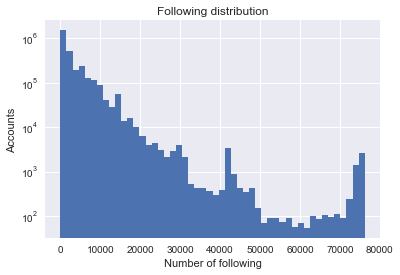

The total amount of following is 10,209,139,778


In [13]:
plt.hist(tweets['following'], log=True, bins=50) 
plt.title('Following distribution')
plt.ylabel('Accounts')
plt.xlabel('Number of following')
plt.show()
print('The total amount of following is {:,}'.format(tweets.following.sum()))

# Tweets Over Time

### General Timeline Analysis

In [15]:
# Tweets over time
# add numerical column of ones to symbolize a tweet
tweets['tweet_counts'] = np.ones(tweets.shape[0])


  
# group by month
general_timeline = tweets.groupby(pd.Grouper(key='publish_date', freq='1M')).sum()
# construct labels
xlabels = list(pd.Series(general_timeline.index.strftime(
    '%Y-%m-%d %H-%M-%S')).apply(lambda x: x[0:7]))
data = []

for col in general_timeline:
    filtered = general_timeline[col].copy()
    trace = go.Scatter(x=xlabels, y=filtered.values, name=col, 
                       fill='tozeroy', mode='lines')
    data.append(trace)

In [16]:
# Create plots for following, followers, updates, tweet_counts

fig = tools.make_subplots(rows=1, cols=2)

fig.append_trace(data[0], 1, 1)
fig.append_trace(data[1], 1, 1)
fig.append_trace(data[2], 1, 1)
fig.append_trace(data[3], 1, 2)

fig['layout'].update(height=600, width=800, title='General Trends Across Time')
py.iplot(fig, filename='styling-names2')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### Language Timeline Analysis

In [17]:
langs = tweets.language.value_counts().iloc[0:13].index.tolist()
langs # top 13 list

['English',
 'Russian',
 'German',
 'Ukrainian',
 'Italian',
 'Serbian',
 'Uzbek',
 'Bulgarian',
 'LANGUAGE UNDEFINED',
 'Arabic',
 'Macedonian',
 'French',
 'Spanish']

In [18]:
language_time = tweets[['language', 'publish_date']]

In [19]:
tweets.publish_date.describe()

count                 2973371
unique                 896684
top       2017-08-16 01:29:00
freq                      202
first     2012-02-02 00:35:00
last      2018-05-30 21:01:00
Name: publish_date, dtype: object

In [20]:
data = trace_generator_language(language_time)
layout = do_layout('Date', 'Number of Tweets', 'Language as a Function of Time')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='styling-names')

In [21]:
# Normalized
data = []

for lang in langs:

    filtered=count_language(lang, language_time)
    strd = pd.Series(filtered.index.strftime('%Y-%m-%d %H-%M-%S'))
    xlabels = list(strd.apply(lambda x: x[0:7]))
    
    trace = dict(
        x=xlabels,
        y=filtered.values,
        hoverinfo='x+y',
        mode='lines',
        stackgroup='one',
        groupnorm='percent',
        name = lang,
    )
    
    data.append(trace)

fig = dict(data=data)
py.iplot(fig, filename='stacked-area-plot-hover', validate=False)

### Account Category Timeline Analysis

In [23]:
# Since the general timeline analysis tweets indicate that there are hardly any tweets 
# before the year 2015, a new dataset is created that filters for 2015 onwards

# Since the values of tweets are minimal before 2015 filter dataframe
tweets_processed = tweets[tweets.publish_date > '2015']
#create dataframe with publish date and account type
accounttype_time = tweets_processed[['publish_date', 'account_category']]

data = trace_generator_account(accounttype_time)
layout = do_layout('Date', 'Number of Tweets','Account Type of Tweets by Month')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='styling-names2')

In [24]:
bubble_data = tweets_processed[['publish_date', 'followers','account_category']]

righttroll = count_followers('RightTroll', bubble_data)
lefttroll = count_followers('LeftTroll', bubble_data)
# newsfeed = count_followers('NewsFeed', bubble_data)
# nonenglish = count_followers('NonEnglish', bubble_data)

trace0 = go.Scatter(
    x=list(pd.Series(righttroll.index.strftime('%Y-%m-%d %H-%M-%S')).apply(lambda x: x[0:7])),
    y=righttroll.tweet_category_num.values,
    mode='markers',
    name='Right Troll',
    marker=dict(
        size=righttroll.followers.values * 0.00001,
        sizemode='area',
        sizeref=2,
        sizemin=4))

trace1 = go.Scatter(
    x=list(pd.Series(lefttroll.index.strftime('%Y-%m-%d %H-%M-%S')).apply(lambda x: x[0:7])),
    y=lefttroll.tweet_category_num.values,
    mode='markers',
    name='Left Troll',
    marker=dict(
        size=lefttroll.followers.values * 0.00001,
        sizemode='area',
        sizeref=2,
        sizemin=4))

data = [trace0, trace1]
layout = do_layout('Date','Number of Tweets in Category',
                   'Social Power (Followers) of Tweet Category by Month')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='styling-names2')

### Investigating Change in Account Category Over Time

In [25]:
# For each author, find dates of first 5 tweets, 5 tweets in November 2016, 5 last tweets

# Find authors that posted in November 2016
nov2016 = tweets_processed[(tweets_processed.publish_date > '2016-11-01')
                                  & (tweets_processed.publish_date < '2016-11-08')]
authors_nov2016 = nov2016.author.unique().categories.values

# create dataframe with only authors that posted during the week of the election
tweets_with_authors_election = tweets_processed[tweets_processed.author.isin(authors_nov2016)]

# Dataframe of authors of interest in first tweet wave
jul2015 = tweets_with_authors_election[(tweets_with_authors_election.publish_date
                                                > '2015-07-01') & 
                                               (tweets_with_authors_election.publish_date
                                                < '2015-08-01')]



In [26]:
tweets_with_authors_election.shape, jul2015.shape, nov2016.shape

((1551005, 14), (17812, 14), (24256, 14))

In [27]:
# Visualize the distribution of account categories between the two selected periods

jul2015_grouping = jul2015.groupby('account_category').sum()
nov2016_grouping = nov2016.groupby('account_category').sum()

jul2015_grouping

,following,followers,updates,tweet_counts
account_category,,,,
Commercial,0,0,0,0.0
Fearmonger,0,0,0,0.0
HashtagGamer,1461826,2849181,1460469,1212.0
LeftTroll,526956,108581,509571,738.0
NewsFeed,82816273,103479115,61403005,8631.0
NonEnglish,4059897,79236975,48890800,4467.0
RightTroll,7906504,31139709,6817164,2764.0
Unknown,0,0,0,0.0


In [28]:
nov2016_grouping

,following,followers,updates,tweet_counts
account_category,,,,
Commercial,0,0,0,0.0
Fearmonger,0,0,0,0.0
HashtagGamer,10523266,13508170,17662651,2594.0
LeftTroll,12632523,14666055,22057836,7699.0
NewsFeed,7319743,19867265,30142509,1124.0
NonEnglish,11324481,62042550,55930512,8598.0
RightTroll,21755037,25374027,26041587,4240.0
Unknown,73,3,3,1.0


In [29]:
tweet_change = pd.DataFrame([jul2015_grouping.tweet_counts, nov2016_grouping.tweet_counts])
tweet_change.index = ['jul2015', 'nov2016']
tweet_change.drop(columns=['Commercial', 'Fearmonger','Unknown'], inplace=True)

# Show a percent change between the two time frames
percent_change = (nov2016_grouping - jul2015_grouping)/jul2015_grouping*100
percent_change.dropna(inplace=True)


In [30]:
data = []
xlabels = ['July 2015', 'November 2016']
for col in tweet_change:
    filtered = tweet_change[col]
    trace = go.Scatter(x=xlabels,y=filtered.values,
                       fill='tozeroy',mode= 'none',name=col)
    data.append(trace)
    

In [31]:
layout = do_layout('Time Period', 'Number of Tweets',
                   'Account Categories Between Two Time Periods of Identical Author Groups')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='styling-names')




# Which States Are Targetted?

In [32]:
# Scrape wikipedia table for american cities and states
website = requests.get('https://simple.wikipedia.org/wiki/List_of_United_States_cities_by_population').text
soup = BeautifulSoup(website,'html5lib')
My_table = soup.find('table',{'class':'wikitable sortable'})
links = My_table.find_all('a')

places = []
for link in links:
    places.append(link.get('title'))
    
    
city_clean = list(filter(None.__ne__, places)) # Drop None values

# Initialize lists for city and state names
cities = []
states = []
for x in range(0, len(city_clean)):
    if x%2 == 0:
        cities.append(city_clean[x].split(',')[0]) # Retrieve only city name, not state
    else:
        states.append(city_clean[x]) # append state name

In [33]:
# Filter for english tweets
tweets_english = tweets_processed[tweets_processed.language == 'English'].copy()
tweets_english.dropna(how='any', axis=0, inplace=True)

# count occurences of tweets for names in cities, and names in states
tweets_city = list(map(lambda x: tweets_english.content.str.contains(x).sum(), cities))
tweets_state = list(map(lambda x: tweets_english.content.str.contains(x).sum(), states))
city_counts = pd.DataFrame(data={'city' : cities, 'city_counts':tweets_city})
state_counts = pd.DataFrame(data={'state' : states, 'state_counts':tweets_state})

cities_states = pd.concat([city_counts, state_counts], axis=1)
df_citycounts_state = cities_states[['city', 'city_counts', 'state']]
grouped_state = df_citycounts_state.groupby('state')['city_counts'].sum()
ordered_state_city = grouped_state.reset_index()

### Mapping by State Occurence

In [34]:
ordered_state = state_counts.drop_duplicates().sort_values(by='state').reset_index(drop=True)
ordered_state['code'] = pd.Series(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL',
                                  'GA', 'HI','ID','IL','IN','IA','KS','KY','LA','MD','MA',
                                  'MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY',
                                  'NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX',
                                  'UT','VA','WA','WA','WI'])
ordered_state.drop(44, inplace=True)
ordered_state.loc[44] = ['Wyoming', 0, 'WY']

In [35]:
data = [ dict(
        type='choropleth',
        colorscale = 'Bluered',
        autocolorscale = False,
        locations = ordered_state['code'],
        z = ordered_state['state_counts'].astype(float).apply(lambda x: np.log(x)),
        locationmode = 'USA-states',
        text = ordered_state['state'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Number of Tweets (Log-value)")
        ) ]

layout = dict(
        title = 'States Mentioned in Tweets',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )

### Timeline analysis of state names in tweets

In [36]:
states_plot = ordered_state.sort_values('state_counts', ascending=False).state.values
plot_states = []
for i in states_plot:
    plot_states.append(extract_states(i, tweets_english))
    data = []

for ind, i in enumerate(states_plot[0:10]):
    strd = pd.Series(plot_states[ind].index.strftime('%Y-%m-%d %H-%M-%S'))
    xlabels = list(strd.apply(lambda x: x[0:7]))
    trace = go.Scatter(x = xlabels, y = plot_states[ind].values, mode = 'lines', name=i,
                      groupnorm='percent')
    data.append(trace)

layout = do_layout('Date', 'Number of Tweets', 'State Mentions over Time')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='line-mode')

### Query By User Input

In [39]:
# Querying for string defined by user

query = wg.Text(value='Query string')
display(query)

Text(value='Query string')

In [43]:
query_df = extract_states(query.get_interact_value(), tweets_english)
strd = pd.Series(query_df.index.strftime('%Y-%m-%d %H-%M-%S'))
xlabels = list(strd.apply(lambda x: x[0:7]))
trace = go.Scatter(x = xlabels, y = query_df.values, mode = 'lines',
                   name=query.get_interact_value(),
                   groupnorm='percent')
data = []
data.append(trace)
layout = do_layout('Date', 'Number of Tweets', '{} Mentions over Time'.format(
    query.get_interact_value()))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='query')

PlotlyRequestError: Hi there, you've reached the threshold of 100 combined image exports and chart saves per 24h period. If you need to raise your daily limit, please consider upgrading to a paid plan
(see: https://plot.ly/products/cloud ).